# Wildfire Image Classification Using a Simple CNN Architecture, MobileNetv2, InceptionResNetv2 & ResNet50v2

### Objectives
* To determine the performance efficacy of MobileNetV2, InceptionResNetV2, and ResNet50V2 in wildfire image classification.
* To compare the results with a baseline model (CNN) to determine the advantages of pretrained models.
* To assess how data augmentation influences the generalisation capability of models.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
data_dir = "/content/drive/My Drive/Data"

categories = ["Fire", "Non_Fire"]
img_size = 128

def create_data(data_dir, categories):
    data = []
    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)

        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                if img_array is None:
#                     print(f"Could not read the image: {os.path.join(path, img)}")
                    continue

                img_resized = cv2.resize(img_array, (img_size, img_size))
                data.append([img_resized, class_num])
            except Exception as e:
                print(e)
    return data

train_data_dir = os.path.join(data_dir, "Train_Data")
test_data_dir = os.path.join(data_dir, "Test_Data")

train_data = create_data(train_data_dir, categories)
test_data = create_data(test_data_dir, categories)

In [14]:
X_train, y_train = [], []
for features, label in train_data:
    X_train.append(features)
    y_train.append(label)

X_test, y_test = [], []
for features, label in test_data:
    X_test.append(features)
    y_test.append(label)


X_train = np.array(X_train).reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

X_test = np.array(X_test).reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)


# Blue and red channels were swapped, so changing their places back
X_train = X_train[:,:, :, [2, 1, 0]]
X_test = X_test[:,:, :, [2, 1, 0]]

In [15]:
X_train = X_train / 255.0
X_test = X_test / 255.0

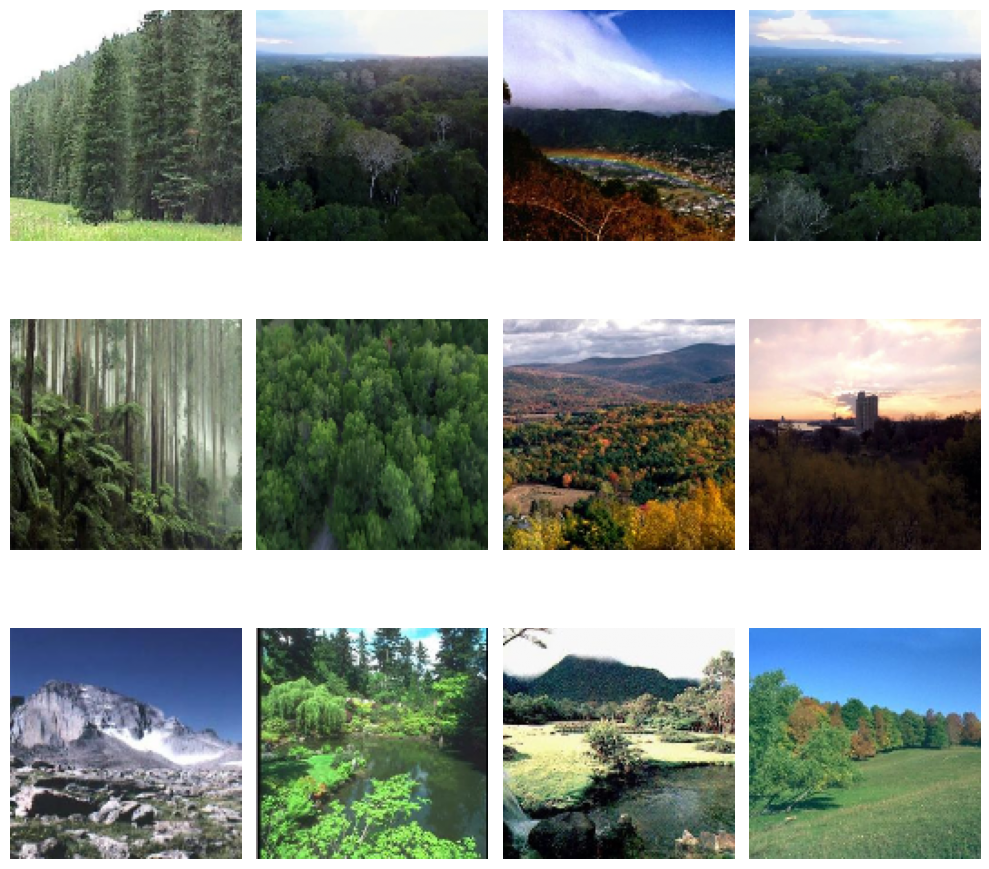

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

num_rows = 3
num_cols = 4

# Create a GridSpec object
gs = gridspec.GridSpec(num_rows, num_cols, height_ratios=[1, 1, 1])

fig = plt.figure(figsize=(10, 10))

for i in range(num_rows):
    for j in range(num_cols):
        index = i*num_cols + j
        ax = fig.add_subplot(gs[i, j])

        if index < X_train.shape[0]:
            ax.imshow(X_train[X_train.shape[0]//2 + index])
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def augment_images(X_train, y_train):

    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    X_train_augmented = []
    y_train_augmented = []

    datagen.fit(X_train)

    for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=len(X_train)):
        X_train_augmented.extend(X_batch)
        y_train_augmented.extend(y_batch)
        break

    X_train_augmented = np.array(X_train_augmented)
    y_train_augmented = np.array(y_train_augmented)

    X_train_combined = np.concatenate((X_train, X_train_augmented), axis=0)
    y_train_combined = np.concatenate((y_train, y_train_augmented), axis=0)

    return X_train_combined, y_train_combined

X_train_aug, y_train_aug = augment_images(X_train, y_train)

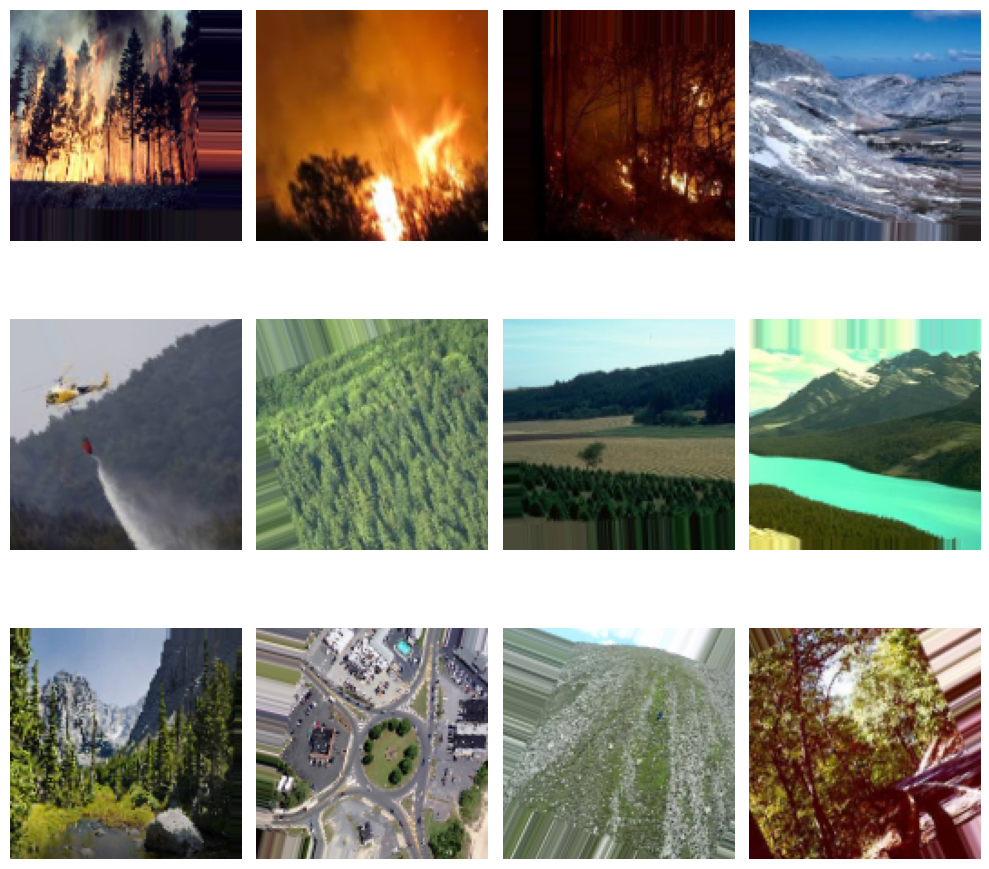

In [ ]:
num_rows = 3
num_cols = 4

# Create a GridSpec object
gs = gridspec.GridSpec(num_rows, num_cols, height_ratios=[1, 1, 1])

fig = plt.figure(figsize=(10, 10))

for i in range(num_rows):
    for j in range(num_cols):
        index = i*num_cols + j
        ax = fig.add_subplot(gs[i, j])

        if index < X_train_aug.shape[0]:
            ax.imshow(X_train_aug[X_train_aug.shape[0]//2 + index])
        ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def augment_and_label_images(X_train, y_train):
    augmentations = ['rotation', 'width_shift', 'height_shift', 'shear', 'zoom', 'flip']

    datagen_configs = [
        {'rotation_range': 30},
        {'width_shift_range': 0.15},
        {'height_shift_range': 0.15},
        {'shear_range': 0.1},
        {'zoom_range': 0.2},
        {'horizontal_flip': True}
    ]

    X_augmented = []
    y_augmented = []
    augmentation_labels = []

    for aug_type, config in zip(augmentations, datagen_configs):
        datagen = ImageDataGenerator(**config)

        for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=len(X_train), shuffle=False):
            X_augmented.extend(X_batch)
            y_augmented.extend(y_batch)
            augmentation_labels.extend([aug_type] * len(X_batch))
            break

    return np.array(X_augmented), np.array(y_augmented), augmentation_labels

X_train_aug, y_train_aug, aug_labels = augment_and_label_images(X_train, y_train)


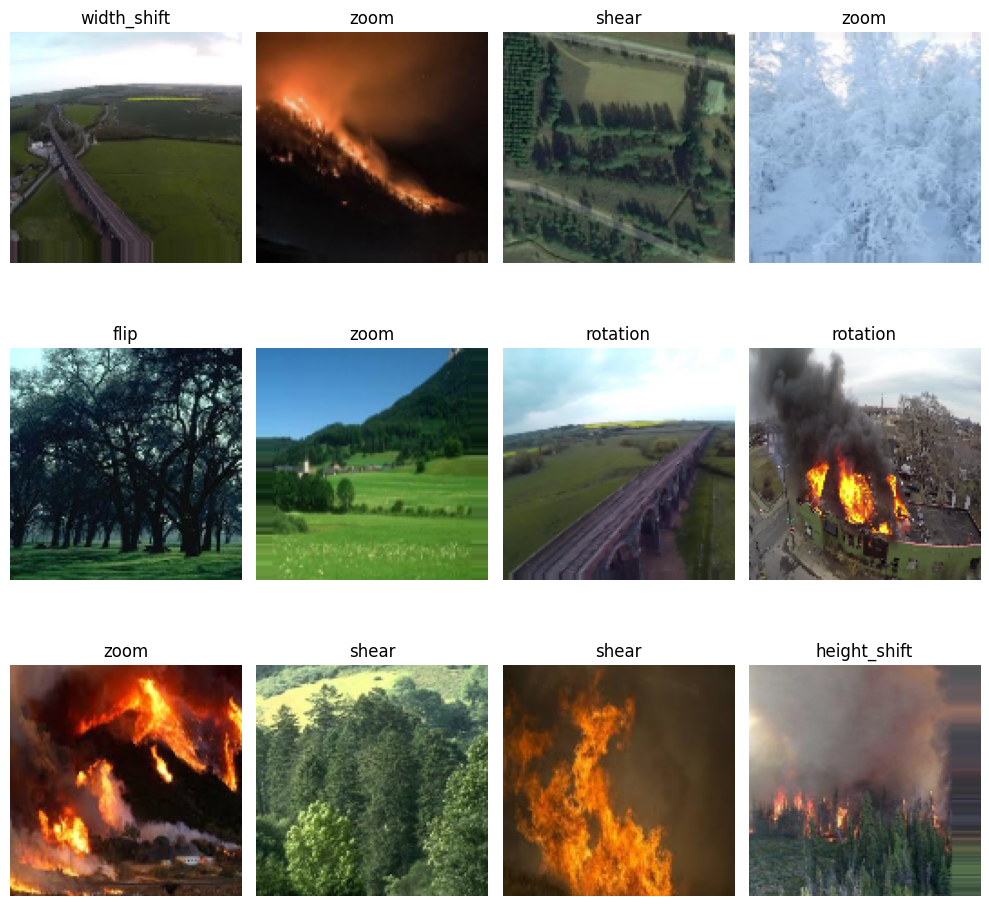

In [ ]:
import random

def shuffle_together(arr1, arr2, arr3):
    combined = list(zip(arr1, arr2, arr3))
    random.shuffle(combined)
    arr1[:], arr2[:], arr3[:] = zip(*combined)
    return arr1, arr2, arr3

# Shuffle the augmented data and their labels
X_train_aug_shuffled, y_train_aug_shuffled, aug_labels_shuffled = shuffle_together(X_train_aug, y_train_aug, aug_labels)

# Visualization
num_rows = 3
num_cols = 4
gs = gridspec.GridSpec(num_rows, num_cols, height_ratios=[1, 1, 1])

fig = plt.figure(figsize=(10, 10))

for i in range(num_rows):
    for j in range(num_cols):
        index = i*num_cols + j
        ax = fig.add_subplot(gs[i, j])

        if index < X_train_aug_shuffled.shape[0]:
            ax.imshow(X_train_aug_shuffled[index])
            ax.set_title(aug_labels_shuffled[index])
        ax.axis('off')

plt.tight_layout()
plt.show()

In [16]:
def augment_images(X_train, y_train):

    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    X_train_augmented = []
    y_train_augmented = []

    datagen.fit(X_train)

    for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=len(X_train)):
        X_train_augmented.extend(X_batch)
        y_train_augmented.extend(y_batch)
        break

    X_train_augmented = np.array(X_train_augmented)
    y_train_augmented = np.array(y_train_augmented)

    X_train_combined = np.concatenate((X_train, X_train_augmented), axis=0)
    y_train_combined = np.concatenate((y_train, y_train_augmented), axis=0)

    return X_train_combined, y_train_combined

X_train_aug, y_train_aug = augment_images(X_train, y_train)

In [17]:
def plot_learning_curves(hist):
    epochs = np.arange(0, len(hist.history['loss'])) + 1
    sns.set(style='ticks')
    fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharex=True)
    ax[0].plot(epochs, hist.history['loss'], label = 'Training loss', marker = 'o', ls = '--', color='r')
    ax[0].plot(epochs, hist.history['val_loss'], label = 'Validation loss', marker = 'o', ls = '--', color='g')

    ax[1].plot(epochs, hist.history['accuracy'], label = 'Training accuracy', marker = 'o', ls = '--', color='r')
    ax[1].plot(epochs, hist.history['val_accuracy'], label = 'Validation accuracy', marker = 'o', ls = '--', color='g')

    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss vs. Epoch')
    ax[0].legend()

    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy vs. Epoch')
    ax[1].legend()
    sns.despine(trim=True, offset=5)

## **Simple CNN Model**

In [ ]:
model = Sequential()

conv_sizes = [16,32,64]
kernel_sizes = [5,3,3,3]


model.add(Input(shape=(img_size, img_size, 3)))

for i in range(len(conv_sizes)):

    model.add(Conv2D(conv_sizes[i], (kernel_sizes[i], kernel_sizes[i])))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 16)      1216      
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 16)     64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 124, 124, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 60, 60, 32)       1

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
116/116 [==============================] - 15s 16ms/step - loss: 0.7903 - accuracy: 0.8459 - val_loss: 0.9860 - val_accuracy: 0.0184
Epoch 2/30
116/116 [==============================] - 1s 10ms/step - loss: 0.3097 - accuracy: 0.8937 - val_loss: 0.7430 - val_accuracy: 0.5499
Epoch 3/30
116/116 [==============================] - 1s 10ms/step - loss: 0.2366 - accuracy: 0.9102 - val_loss: 0.6674 - val_accuracy: 0.7408
Epoch 4/30
116/116 [==============================] - 1s 10ms/step - loss: 0.2299 - accuracy: 0.9219 - val_loss: 0.2710 - val_accuracy: 0.9241
Epoch 5/30
116/116 [==============================] - 1s 10ms/step - loss: 0.1720 - accuracy: 0.9317 - val_loss: 0.2646 - val_accuracy: 0.9154
Epoch 6/30
116/116 [==============================] - 1s 10ms/step - loss: 0.1871 - accuracy: 0.9295 - val_loss: 0.1533 - val_accuracy: 0.9544
Epoch 7/30
116/116 [==============================] - 1s 10ms/step - loss: 0.1750 - accuracy: 0.9373 - val_loss: 0.2513 - val_accuracy: 0.952

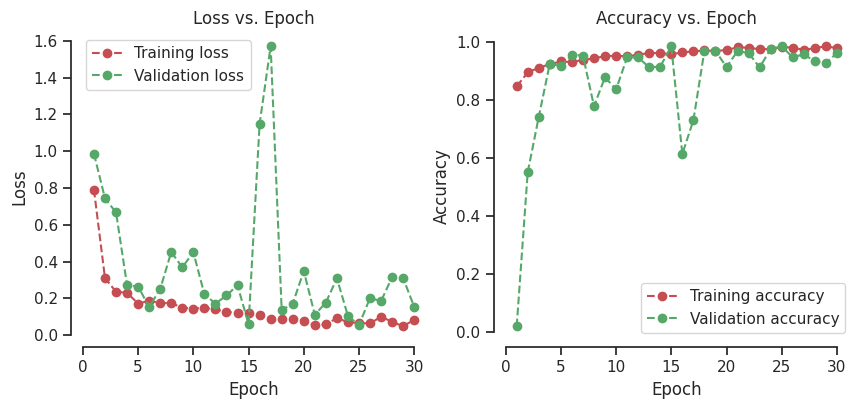

In [ ]:
plot_learning_curves(history)

### Model Evaluation

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

y_pred = model.predict(X_test)
y_pred_classes = [1 if pred > 0.5 else 0 for pred in y_pred]

4/4 [==============================] - 0s 19ms/step - loss: 0.3675 - accuracy: 0.9286
Test accuracy: 0.9285714030265808
4/4 [==============================] - 0s 4ms/step


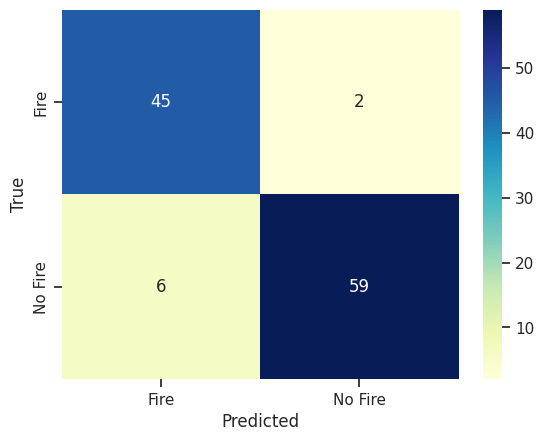

In [ ]:
# Generate confusion matrix (assuming y_test and y_pred_classes are already defined)
cm = confusion_matrix(y_test, y_pred_classes)

sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["Fire", "No Fire"], yticklabels=["Fire", "No Fire"])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        47
           1       0.97      0.91      0.94        65

    accuracy                           0.93       112
   macro avg       0.92      0.93      0.93       112
weighted avg       0.93      0.93      0.93       112



### Visualizing Sample Images

In [ ]:
def show_images(data_dir, category, num_images=5):
    path = os.path.join(data_dir, category)
    image_files = os.listdir(path)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))

    displayed_images = 0
    for image_file in image_files:
        if displayed_images >= num_images:
            break

        img = cv2.imread(os.path.join(path, image_file))

        if img is None:
            print(f"Unable to load image {image_file}. Skipping...")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[displayed_images].imshow(img)
        axes[displayed_images].set_title(f"{category} {displayed_images + 1}")
        axes[displayed_images].axis("off")
        displayed_images += 1

    plt.show()

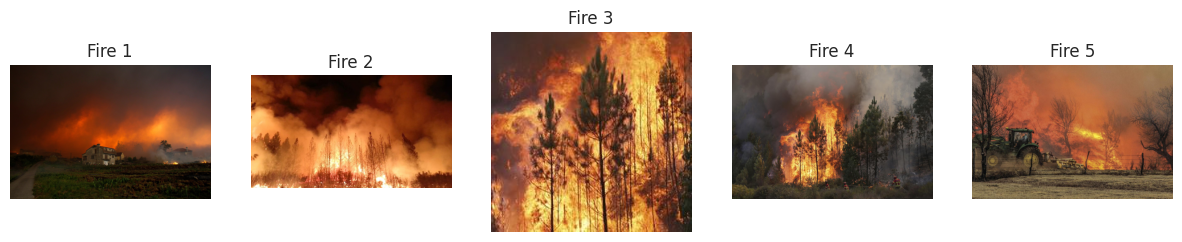

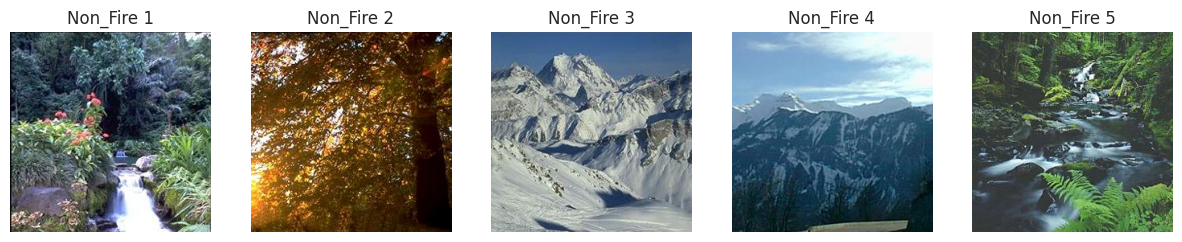

In [ ]:
show_images(train_data_dir, "Fire")
show_images(train_data_dir, "Non_Fire")

In [ ]:
model.save("forest_fire_classifier.h5")

# **Transfer Learning Models**
## **MobileNetV2**

In [109]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_size,img_size,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.GlobalAveragePooling2D(),
                              tf.keras.layers.Dense(2046, activation = 'relu'),
                              tf.keras.layers.Dense(1024, activation = 'relu'),
                              tf.keras.layers.Dropout(rate = 0.2),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.00000899),
                loss = "binary_crossentropy",
                metrics=["accuracy"])

In [110]:
history1 = model.fit(X_train,y_train, epochs = 20, batch_size=32, validation_split = 0.2)

Epoch 1/20
116/116 [==============================] - 6s 23ms/step - loss: 0.3550 - accuracy: 0.8761 - val_loss: 0.2598 - val_accuracy: 0.9328
Epoch 2/20
116/116 [==============================] - 1s 12ms/step - loss: 0.1614 - accuracy: 0.9593 - val_loss: 0.2512 - val_accuracy: 0.9208
Epoch 3/20
116/116 [==============================] - 1s 12ms/step - loss: 0.1162 - accuracy: 0.9661 - val_loss: 0.2401 - val_accuracy: 0.9154
Epoch 4/20
116/116 [==============================] - 1s 12ms/step - loss: 0.0921 - accuracy: 0.9740 - val_loss: 0.1993 - val_accuracy: 0.9284
Epoch 5/20
116/116 [==============================] - 1s 12ms/step - loss: 0.0791 - accuracy: 0.9786 - val_loss: 0.1794 - val_accuracy: 0.9295
Epoch 6/20
116/116 [==============================] - 1s 12ms/step - loss: 0.0689 - accuracy: 0.9799 - val_loss: 0.1608 - val_accuracy: 0.9393
Epoch 7/20
116/116 [==============================] - 1s 13ms/step - loss: 0.0593 - accuracy: 0.9843 - val_loss: 0.1591 - val_accuracy: 0.9393

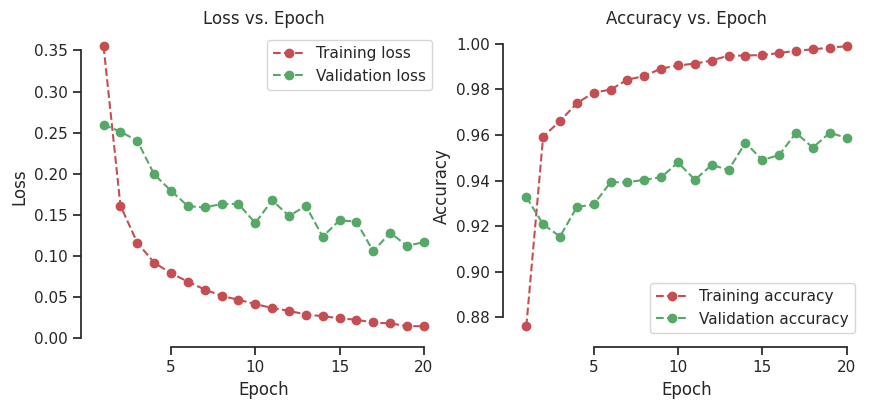

In [111]:
plot_learning_curves(history1)

In [112]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

y_pred = model.predict(X_test)
y_pred_classes = [1 if pred > 0.5 else 0 for pred in y_pred]

4/4 [==============================] - 0s 10ms/step - loss: 0.1519 - accuracy: 0.9464
Test accuracy: 0.9464285969734192
4/4 [==============================] - 1s 9ms/step


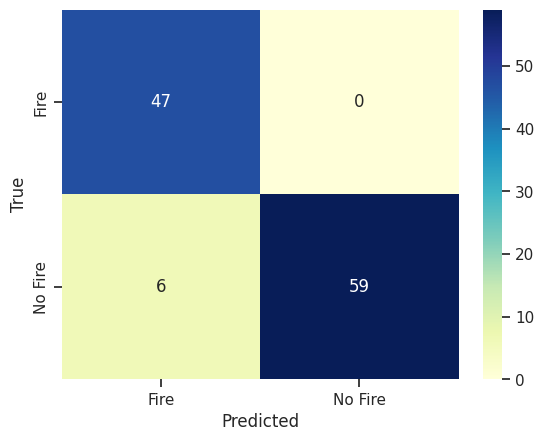

In [113]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["Fire", "No Fire"], yticklabels=["Fire", "No Fire"])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [114]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        47
           1       1.00      0.91      0.95        65

    accuracy                           0.95       112
   macro avg       0.94      0.95      0.95       112
weighted avg       0.95      0.95      0.95       112





```
# This is formatted as code
```

## **InceptionResNetV2**

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(input_shape=(img_size,img_size,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(2046, activation = 'relu'),
                              tf.keras.layers.Dropout(rate = 0.2),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.00009, beta_1=0.9, beta_2=0.999),
                loss = "binary_crossentropy",
                metrics=["accuracy"])

In [ ]:
#history2 = model.fit(X_train_aug,y_train_aug,epochs = 20, batch_size=32, validation_split = 0.2)
history2 = model.fit(X_train_aug,y_train_aug,epochs = 20, batch_size=32, validation_split = 0.2)

Epoch 1/20
231/231 [==============================] - 23s 54ms/step - loss: 0.2482 - accuracy: 0.9255 - val_loss: 0.2085 - val_accuracy: 0.9338
Epoch 2/20
231/231 [==============================] - 9s 37ms/step - loss: 0.1203 - accuracy: 0.9622 - val_loss: 0.1324 - val_accuracy: 0.9550
Epoch 3/20
231/231 [==============================] - 9s 38ms/step - loss: 0.0846 - accuracy: 0.9714 - val_loss: 0.1685 - val_accuracy: 0.9420
Epoch 4/20
231/231 [==============================] - 9s 38ms/step - loss: 0.0565 - accuracy: 0.9816 - val_loss: 0.6777 - val_accuracy: 0.8655
Epoch 5/20
231/231 [==============================] - 9s 37ms/step - loss: 0.0623 - accuracy: 0.9780 - val_loss: 0.1035 - val_accuracy: 0.9675
Epoch 6/20
231/231 [==============================] - 9s 38ms/step - loss: 0.0265 - accuracy: 0.9923 - val_loss: 0.1059 - val_accuracy: 0.9653
Epoch 7/20
231/231 [==============================] - 9s 38ms/step - loss: 0.0163 - accuracy: 0.9961 - val_loss: 0.1115 - val_accuracy: 0.966

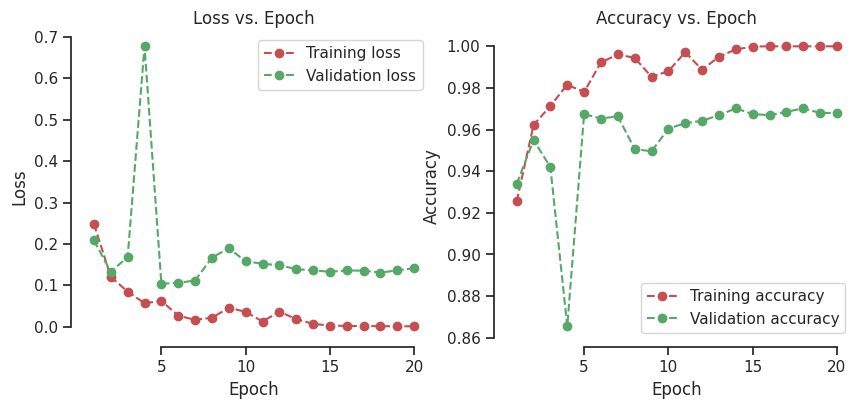

In [ ]:
plot_learning_curves(history2)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

y_pred = model.predict(X_test)
y_pred_classes = [1 if pred > 0.5 else 0 for pred in y_pred]

4/4 [==============================] - 0s 33ms/step - loss: 0.0808 - accuracy: 0.9821
Test accuracy: 0.9821428656578064
4/4 [==============================] - 3s 28ms/step


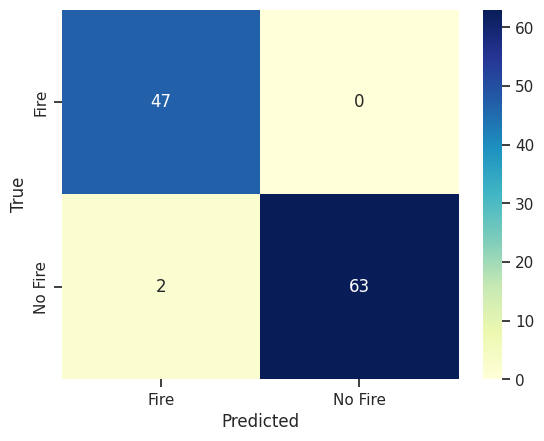

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        47
           1       1.00      0.97      0.98        65

    accuracy                           0.98       112
   macro avg       0.98      0.98      0.98       112
weighted avg       0.98      0.98      0.98       112



In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["Fire", "No Fire"], yticklabels=["Fire", "No Fire"])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_test, y_pred_classes))

## **ResNet50V2**

In [ ]:
base_model = tf.keras.applications.ResNet50V2(input_shape=(img_size,img_size,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(2046, activation = 'relu'),
                              tf.keras.layers.Dense(1024, activation = 'relu'),
                              tf.keras.layers.Dropout(rate = 0.2),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.00009, beta_1=0.9, beta_2=0.999),
                loss = "binary_crossentropy",
                metrics=["accuracy"])

In [ ]:
history3 = model.fit(X_train_aug,y_train_aug,epochs = 20, batch_size=32, validation_split = 0.2)

Epoch 1/20
231/231 [==============================] - 10s 28ms/step - loss: 0.2018 - accuracy: 0.9417 - val_loss: 0.1322 - val_accuracy: 0.9544
Epoch 2/20
231/231 [==============================] - 5s 21ms/step - loss: 0.0350 - accuracy: 0.9871 - val_loss: 0.1131 - val_accuracy: 0.9593
Epoch 3/20
231/231 [==============================] - 5s 21ms/step - loss: 0.0107 - accuracy: 0.9973 - val_loss: 0.1489 - val_accuracy: 0.9599
Epoch 4/20
231/231 [==============================] - 5s 21ms/step - loss: 0.0042 - accuracy: 0.9985 - val_loss: 0.1615 - val_accuracy: 0.9653
Epoch 5/20
231/231 [==============================] - 5s 22ms/step - loss: 7.3079e-04 - accuracy: 1.0000 - val_loss: 0.1705 - val_accuracy: 0.9675
Epoch 6/20
231/231 [==============================] - 5s 22ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.1982 - val_accuracy: 0.9664
Epoch 7/20
231/231 [==============================] - 5s 22ms/step - loss: 9.8337e-04 - accuracy: 0.9997 - val_loss: 0.2447 - val_accurac

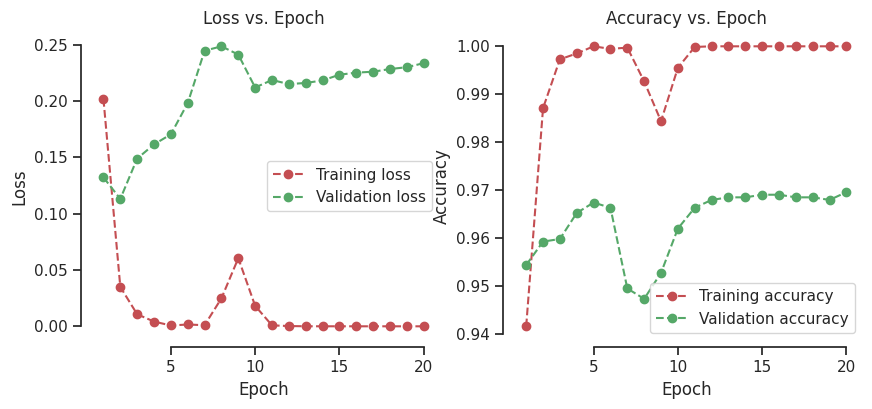

In [ ]:
plot_learning_curves(history3)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

y_pred = model.predict(X_test)
y_pred_classes = [1 if pred > 0.5 else 0 for pred in y_pred]

4/4 [==============================] - 0s 15ms/step - loss: 0.0701 - accuracy: 0.9821
Test accuracy: 0.9821428656578064
4/4 [==============================] - 1s 14ms/step


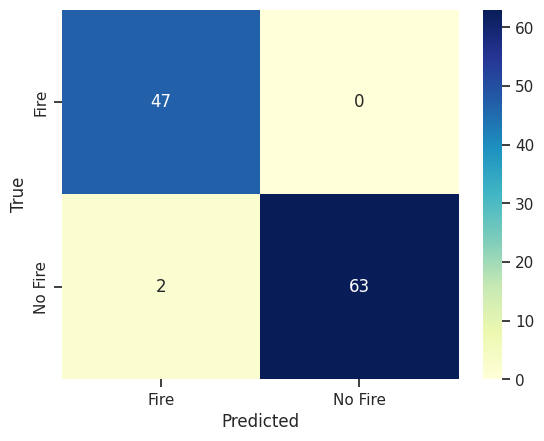

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        47
           1       1.00      0.97      0.98        65

    accuracy                           0.98       112
   macro avg       0.98      0.98      0.98       112
weighted avg       0.98      0.98      0.98       112



In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["Fire", "No Fire"], yticklabels=["Fire", "No Fire"])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_test, y_pred_classes))